In [1]:
#Import libraries for doing image analysis
from skimage.io import imread
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier as RF
import glob
import os
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from matplotlib import colors
from pylab import cm
from skimage import segmentation
from skimage.morphology import watershed
from skimage import measure
from skimage import morphology
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage.feature import peak_local_max
# make graphics inline
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/Users/kewindereniewicz/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


## Importing the data

In [3]:
df_train_labels = pd.read_csv('data/train_onelabel.csv')
df_train_labels.head()

,image,class
0,132103.jpg,0
1,66467.jpg,0
2,9143.jpg,0
3,20630.jpg,0
4,33689.jpg,0


In [4]:
df_label_map = pd.read_csv('data/label_map.txt', sep=" ", header=None, names=["label", "class"])
df_label_map.head()

,label,class
0,unknown_unclassified,0
1,unknown_sticks,1
2,protist_star,2
3,copepod_cyclopoid_oithona,3
4,hydromedusae_solmundella,4


## Preparing Training Data

In [5]:
IMG_SIZE = 64

def preprocess_img(img):
    # rescale to standard size
    img = resize(img, (IMG_SIZE, IMG_SIZE))
    return img

data/train_images/100088.jpg


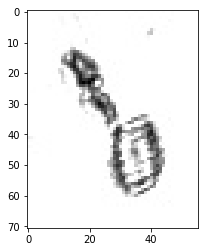

In [6]:
# Example image
example_file = glob.glob('data/train_images/*.jpg')[12]
print(example_file)
im = imread(example_file, as_grey=True)
plt.imshow(im, cmap=cm.gray)
plt.show()

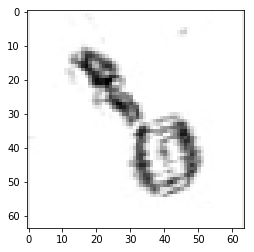

In [7]:
new_im = preprocess_img(im)
plt.imshow(new_im, cmap=cm.gray)
plt.show()

In [8]:
def get_label(file_name):
    return df_train_labels.loc[df_train_labels['image'] == file_name]['class'].values[0]

In [9]:
#get the total training images
number_of_images = 0
for _, _, fileNames in os.walk('data/train_images'): 
    for fileName in fileNames:
        # Only read in the images
        if fileName[-4:] != ".jpg":
            continue
        number_of_images += 1
        
print('Number of images:', number_of_images)

imgs = []
labels = []
i = 0

print('Reading images...')

for root, _, file_names in os.walk('data/train_images'): # change in train_images
    for file_name in file_names:
        # Only read in the images
        if fileName[-4:] != ".jpg":
            continue
        
        img_path = "{0}{1}{2}".format(root, os.sep, file_name)
        img = preprocess_img(imread(img_path, as_grey=True))
        imgs.append(img)
        
        label = get_label(file_name)
        labels.append(label)
        
        i += 1
        # report progress for each 5% done  
        report = [int((j+1)*number_of_images/20.) for j in range(20)]
        if i in report: print(np.ceil(i *100.0 / number_of_images), "% done")

Number of images: 24204
Reading images...
5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done
100.0 % done


In [10]:
X = np.array(imgs, dtype='float32')
X.shape

(24204, 64, 64)

In [11]:
X = X.reshape(X.shape[0], 1, IMG_SIZE, IMG_SIZE)
X.shape

(24204, 1, 64, 64)

In [12]:
Y = np_utils.to_categorical(labels)
Y.shape

(24204, 121)

In [13]:
#get the total training images
number_of_images = 0
for _, _, fileNames in os.walk('data/test_images'): 
    for fileName in fileNames:
        # Only read in the images
        if fileName[-4:] != ".jpg":
            continue
        number_of_images += 1
        
print('Number of images:', number_of_images)

imgs = []
test_img_names = []
i = 0

print('Reading test images...')

for root, _, file_names in os.walk('data/test_images'): # change in train_images
    for file_name in file_names:
        # Only read in the images
        if fileName[-4:] != ".jpg":
            continue
        
        img_path = "{0}{1}{2}".format(root, os.sep, file_name)
        img = preprocess_img(imread(img_path, as_grey=True))
        imgs.append(img)
        
        test_img_names.append(file_name)
        
        i += 1
        # report progress for each 5% done  
        report = [int((j+1)*number_of_images/20.) for j in range(20)]
        if i in report: print(np.ceil(i *100.0 / number_of_images), "% done")

Number of images: 6132
Reading test images...
5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done
100.0 % done


In [14]:
X_test = np.array(imgs, dtype='float32')
X_test.shape

(6132, 64, 64)

In [15]:
X_test = X_test.reshape(X_test.shape[0], 1, IMG_SIZE, IMG_SIZE)
X_test.shape

(6132, 1, 64, 64)

## Define Keras Model

In [16]:
NUM_CLASSES = 121

def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', 
                     input_shape=(1, IMG_SIZE, IMG_SIZE), 
                     activation='relu', data_format='channels_first'))
    model.add(Conv2D(32, (3, 3), activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu', data_format='channels_first'))
    model.add(Conv2D(64, (3, 3), activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu', data_format='channels_first'))
    model.add(Conv2D(128, (3, 3), activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(512, activation='relu')) # added
    #model.add(Dropout(0.2)) # added
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model


model = cnn_model()

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [21]:
# Hyperparameter optimization when creating a model

from hyperopt.base import Trials
from hyperopt import STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from sklearn.model_selection import train_test_split

# artificial function returning train and test data
def data():
    IMG_SIZE = 64
    
    df_train_labels = pd.read_csv('data/train_onelabel.csv')

    number_of_images = 0
    for _, _, fileNames in os.walk('data/train_images'): 
        for fileName in fileNames:
            # Only read in the images
            if fileName[-4:] != ".jpg":
                continue
            number_of_images += 1

    print('Number of images:', number_of_images)

    imgs = []
    labels = []
    i = 0

    print('Reading images...')

    for root, _, file_names in os.walk('data/train_images'): # change in train_images
        for file_name in file_names:
            # Only read in the images
            if fileName[-4:] != ".jpg":
                continue

            img_path = "{0}{1}{2}".format(root, os.sep, file_name)
            img = resize(imread(img_path, as_grey=True), (121, 121))
            imgs.append(img)

            label = df_train_labels.loc[df_train_labels['image'] == file_name]['class'].values[0]
            labels.append(label)

            i += 1
            # report progress for each 5% done  
            report = [int((j+1)*number_of_images/20.) for j in range(20)]
            if i in report: print(np.ceil(i *100.0 / number_of_images), "% done")
    X = np.array(imgs, dtype='float32')
    X = X.reshape(X.shape[0], 1, 121, 121)
    Y = np_utils.to_categorical(labels)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    return x_train, y_train, x_test, y_test

def create_model(x_train, y_train, x_test, y_test):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', 
                     input_shape=(1, 121, 121), 
                     activation='relu', data_format='channels_first'))
    model.add(Conv2D(32, (3, 3), activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu', data_format='channels_first'))
    model.add(Conv2D(64, (3, 3), activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu', data_format='channels_first'))
    model.add(Conv2D(128, (3, 3), activation='relu', data_format='channels_first'))
    
    if conditional({{choice(['three', 'four'])}}) == 'four':
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout({{uniform(0, 1)}}))
        
    model.add(Flatten())
    model.add(Dense(512, activation='relu')) # added
    model.add(Dropout({{uniform(0, 1)}})) # added
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(121, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

    model.fit(x_train, y_train,
              batch_size={{choice([32, 64])}},
              epochs=1,
              verbose=2,
              validation_data=(x_test, y_test))
    
    score, acc = model.evaluate(x_test, y_test, verbose=0)
    
    print('Test accuracy:', acc)
    
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                        notebook_name='AML_17_Kaggle_Plankton_Identification')

X_train, Y_train, X_test, Y_test = data()

print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))

print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    from skimage.io import imread
except:
    pass

try:
    from skimage.transform import resize
except:
    pass

try:
    from sklearn.ensemble import RandomForestClassifier as RF
except:
    pass

try:
    import glob
except:
    pass

try:
    import os
except:
    pass

try:
    from sklearn import cross_validation
except:
    pass

try:
    from sklearn.cross_validation import StratifiedKFold as KFold
except:
    pass

try:
    from sklearn.metrics import classification_report
except:
    pass

try:
    from matplotlib import pyplot as plt
except:
    pass

try:
    from matplotlib import colors
except:
    pass

try:
    from pylab import cm
except:
    pass

try:
    from skimage import segmentation
except:
    pass

try:
    from skimage.morphology import watershed
except:
    pass

try:
    from skimage import measure
except:
    pass

try:
    from skimage import morphology
except:
    pass

try:
    import numpy as np
except:
    pass

try:

NameError: name 'x_train' is not defined

In [ ]:
model.fit(X, Y, batch_size=32, epochs=25, verbose=1)

Epoch 1/25
24204/24204 [==============================] - 2101s 87ms/step - loss: 4.2107 - acc: 0.0940
Epoch 2/25
24204/24204 [==============================] - 2199s 91ms/step - loss: 3.8753 - acc: 0.1347
Epoch 3/25
 8320/24204 [=========>....................] - ETA: 28:31 - loss: 3.5887 - acc: 0.1855

In [ ]:
model.summary()

$ CategoryAccuracy = \frac{1}{N} \sum_{y_i = \hat{y}_i} 1,$

In [ ]:
score = model.evaluate(X, Y, verbose=0)
print("Accuracy: ", score[1])
#.68

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
y_pred[:4]

In [ ]:
df_submit = pd.DataFrame(list(zip(test_img_names, y_pred)),columns=['image','class'])
df_submit.head()

In [ ]:
# export dataframe to csv file for submission
df_submit.to_csv('submission', sep=',', index=False)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.cross_validation import train_test_split

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(X)

# Reinitialize model and compile
model = cnn_model()

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train again
epochs = 10
batch_size = 32
model.fit_generator(datagen.flow(X, Y, batch_size=batch_size), steps_per_epoch=X.shape[0], epochs=epochs)

In [ ]:
score = model.evaluate(X, Y, verbose=0)
print("Accuracy: ", score[1])

y_pred = model.predict_classes(X_test)

In [ ]:
df_submit2 = pd.DataFrame(list(zip(test_img_names, y_pred)),columns=['image','class'])
df_submit2.head()

In [ ]:
# export dataframe to csv file for submission
df_submit2.to_csv('submission2.csv', sep=',', index=False)

## Plot augmented images

In [ ]:
# define data preparation
datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
# fit parameters from data
datagen.fit(X)
# configure batch size and retrieve one batch of images
for X_batch, Y_batch in datagen.flow(X, Y, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(25, 25), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break
    


In [ ]:
# Flip images vertically
datagen = ImageDataGenerator(vertical_flip=True)
# fit parameters from data
datagen.fit(X)
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X, Y, batch_size=9, shuffle=False):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(25, 25), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

In [ ]:
# Flip images vertically
datagen = ImageDataGenerator(vertical_flip=True)
# fit parameters from data
datagen.fit(X)
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X, Y, batch_size=9, shuffle=False):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(25, 25), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break